In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import pysco

import ast
import os
#import cosmotable
import pysco.cosmotable
import pysco.solver # ` is importing the `solver` module from the `pysco` package. This statement allows you to access and use the functions, classes, and variables defined in the `solver` module within your current Python script or program.
import pysco.initial_conditions
import pysco.integration
import pysco.utils
from typing import Dict
import pandas as pd
import logging
from rich.logging import RichHandler
import iostream
from time import perf_counter
import sys

from SheetUtils import *
# examples/example.py
from pathlib import Path


In [7]:
#path = Path(__file__).parent.absolute()
#"../../examples/pk_lcdmw7v2.dat"
path = "/tmp"
param = {
    "nthreads": 1,
    "theory": "newton",
    # "fR_logfR0": 5,
    # "fR_n": 1,
    # "mond_function": "simple",
    # "mond_g0": 1.2,
    # "mond_scale_factor_exponent": 0,
    # "mond_alpha": 1,
    # "parametrized_mu0": 0.1,
    "H0": 72,
    "Om_m": 0.25733,
    "T_cmb": 2.726,
    "N_eff": 3.044,
    "w0": -1.0,
    "wa": 0.0,
    "boxlen": 200,
    "ncoarse": 7,
    "npart": 256**3,
    "z_start": 49,
    "seed": 42,
    "position_ICS": "center",
    "fixed_ICS": False,
    "paired_ICS": False,
    "dealiased_ICS": False,
    "power_spectrum_file": f"{path}/pk_lcdmw7v2.dat",
    "initial_conditions": "2LPT",
    "base": f"{path}/",
    "z_out": "[10, 5, 2, 1, 0.5, 0]",
    "output_snapshot_format": "HDF5",
    "save_power_spectrum": "yes",
    "integrator": "leapfrog",
    "n_reorder": 50,
    "mass_scheme": "TSC",
    "Courant_factor": 1.0,
    "max_aexp_stepping": 10,
    "linear_newton_solver": "multigrid",
    "gradient_stencil_order": 5,
    "Npre": 2,
    "Npost": 1,
    "epsrel": 1e-2,
    "extra": "newton_multigrid_ncoarse7",
    "verbose": 1,
}

# Run simulation
#pysco.run(param)
#print("Run completed!")
z_out = ast.literal_eval(param["z_out"])
power_directory = f"{param['base']}/power"
os.makedirs(power_directory, exist_ok=True)
for i in range(len(z_out) + 1):
    output_directory = f"{param['base']}/output_{i:05d}"
    os.makedirs(output_directory, exist_ok=True)

tables = pysco.cosmotable.generate(param)
# aexp and t are overwritten if we read a snapshot
param["aexp"] = 1.0 / (1 + param["z_start"])
pysco.utils.set_units(param)
logging.warning(f"\n[bold blue]----- Initial conditions -----[/bold blue]\n")
p, v = pysco.initial_conditions.generate(param, tables)


[bold blue]----- Initial conditions -----[/bold blue]



In [8]:
ds, pl = pysco_displacement_field_and_initial_coordinates(p, box=[0,1])
dsl = np.linalg.norm(ds, axis=1)
Ndim = np.int64(p.shape[0]**.333333334) # assume we had Ndim**3 particles in a grid on cubic box
p3d = p.reshape(Ndim,Ndim,Ndim,3)  # reshape the array so we have the Lagrangian coordinates with 3D indexing
# This next step reverses the xyz ordering to zyx ordering and go from C to fortran order and vice versa
# One should read in the initial conditions of a simulation and check that all tetrahedra volumes 
# come out positive. If they are all negative comment out this next line and try again.
p3d = p3d[:,:,:,::-1] 

In [9]:
voxvol = get_voxel_volumes(Ndim-1,p3d)
cen = get_tet_centroids(Ndim-1,p3d)

vol = get_tet_volumes(Ndim-1,p3d)

In [69]:
#downsampled versions
vol2 = get_tet_volumes(Ndim//2-1,p3d[:-1:2,:-1:2,:-1:2,:])
#vol3 = get_tet_volumes(Ndim//3-1,p3d[:-1:3,:-1:3,:-1:3,:])
vol3 = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            vol3 = np.concatenate([vol3, get_tet_volumes(Ndim//3-1,p3d[i:-1:3,j:-1:3,k:-1:3,:]).flatten()])
vol4 = []
ct = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            ct += 1
#            print(i,j,k, ct)
            vol4 = np.concatenate([vol4, get_tet_volumes(Ndim//4-1,p3d[i:-1:4,j:-1:4,k:-1:4,:]).flatten()])

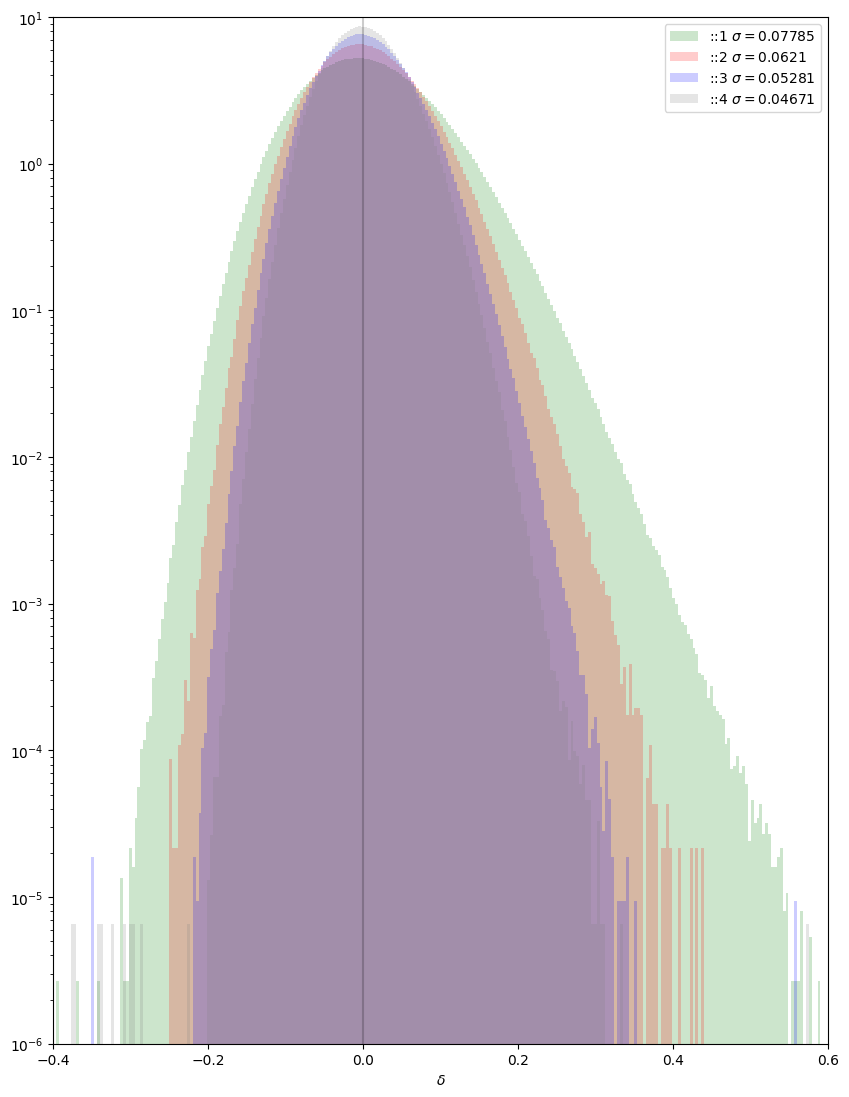

In [70]:
# show the single stream region that is the voids as the regions with positive volume
mpvol = vol[vol > 0].flatten()*Ndim**3*6
mpvol2 = vol2[vol2 > 0].flatten()*Ndim**3*6/2**3
mpvol3 = vol3[vol3 > 0].flatten()*Ndim**3*6/3**3
mpvol4 = vol4[vol4 > 0].flatten()*Ndim**3*6/4**3
nbins = 800
#mvoxvol = np.fabs(voxvol.flatten())/(np.prod(bext)/Ndim**3) # every particle in ICs has volume of 1 this way 
vb = plt.hist(np.abs(1/mpvol+1e-32)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="green",label=f"::1 $\sigma=${np.std(1./mpvol-1):.4g}",density=True)
vb2 = plt.hist(np.abs(1/mpvol2+1e-32)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="red",label=f"::2 $\sigma=${np.std(1./mpvol2-1):.4g}",density=True)
vb3 = plt.hist(np.abs(1/mpvol3+1e-32)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="blue",label=f"::3 $\sigma=${np.std(1./mpvol3-1):.4g}",density=True)
vb4 = plt.hist(np.abs(1/mpvol4+1e-32)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="grey",label=f"::4 $\sigma=${np.std(1./mpvol4-1):.4g}",density=True)
plt.xlabel(r"$\delta$")
plt.axvline(0,color="black",alpha=0.2)
plt.ylim(1e-6,1e1)
plt.xlim(-0.4,0.6)
plt.legend();

In [67]:
vol2.shape, vol3.shape, vol4.shape

((127, 127, 127, 6), (28449792,), (40507614,))

In [61]:
256**3*6

100663296

In [51]:
vol3.append(3)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [49]:
for i in range(2):
    print(i)

0
1
